# Lab 7 & 8
Lucas Street, 1874989

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from scipy.signal import argrelmax
from hera_cal.io import HERAData

In [55]:
filename = '../Lab 5/zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)

def get_spectrogram(hd, selected_times, freq_channels, *args, read_args={}, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels, **read_args)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, *args, colorbar=True, **kwargs):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto', **kwargs)
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('$\Delta t$ (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])
    
def plot_histogram(hist_data, max_amplitude=0.05, nbins=300, errorbars=False):
    hist_data = hist_data[hist_data < max_amplitude]
    hist, edges = np.histogram(hist_data, bins=nbins, density=True)
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    if errorbars:
        plt.bar(edges[:-1], hist, width=edges[1] - edges[0], yerr=np.sqrt(hist))
    else:
        plt.bar(edges[:-1], hist, width=edges[1] - edges[0])
    return hist

def plot_lognormal_fit(hist_data, max_amplitude=0.4, *args, **kwargs):
    sigma, mean, scale = stats.lognorm.fit(hist_data)
    dist = stats.lognorm(sigma, mean, scale)
    x = np.linspace(0, max_amplitude, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, *args, **kwargs)
    plt.yscale('log')
    plt.xlim(0, max_amplitude)
    plt.ylim(1e-4)
    plt.legend(['Lognormal fit', 'Background'])
    print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")
    return sigma, mean, scale

## Signal Removal

In [4]:
np.sort(hd.antenna_numbers)

array([  0,   1,   2,  11,  12,  13,  14,  23,  24,  25,  26,  27,  36,
        37,  38,  39,  40,  41,  50,  51,  52,  53,  54,  55,  65,  66,
        67,  68,  69,  70,  71,  82,  83,  84,  85,  86,  87,  88,  98,
       120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143])

In the previous labs we've seen how the telescope data contains both a relatively constant signal from the sky (which includes signals from radio galaxies) as well as contamination from the immediate environment. To actually attempt to find a background distribution for our data, we have to remove both the sky signal and the contaminants. Removing the sky signal isn't too hard - because it is essentially constant in time, we can take the differences (or _diffs_) of consecutive frequency spectra for one baseline, and plot it as a spectrogram:

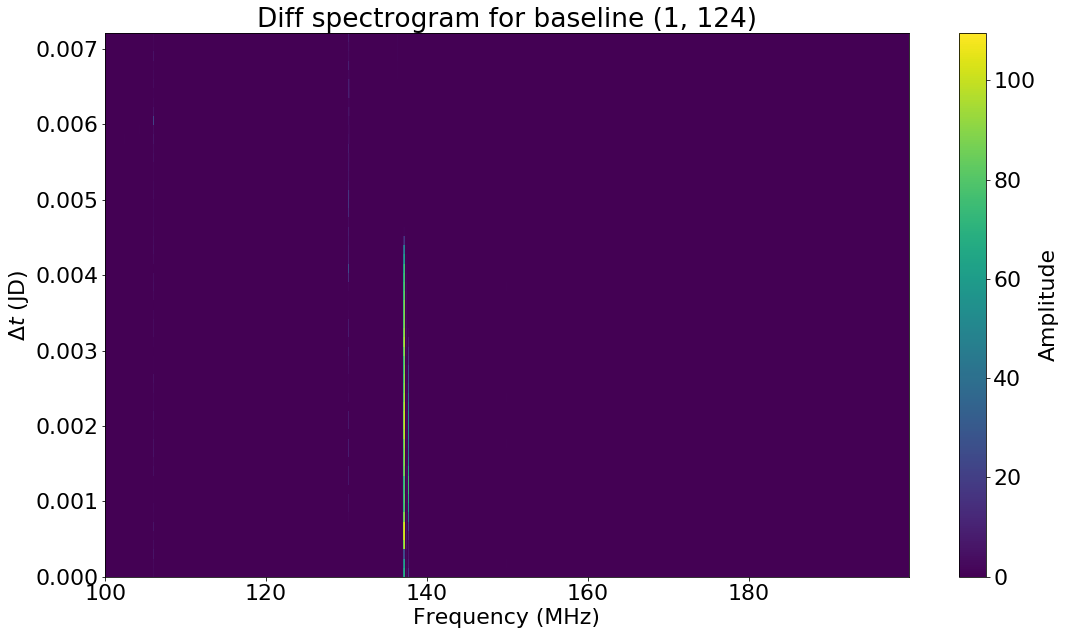

In [5]:
baseline = (1, 124)
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:], np.arange(0, 1024), 'XX', read_args={'bls': [baseline]})
data = np.diff(data, axis=0)
times = times[:-1]
plt.title(f"Diff spectrogram for baseline {baseline}")
plot_spectrogram(freqs_mhz, times, data)

The above plot gives us an idea of what non-sky signals are changing in time, since the contaminating signals tend to be highly variable (shown above with large changes in amplitude). Let's plot the average spectrum for each diff that we see above across all time intervals:

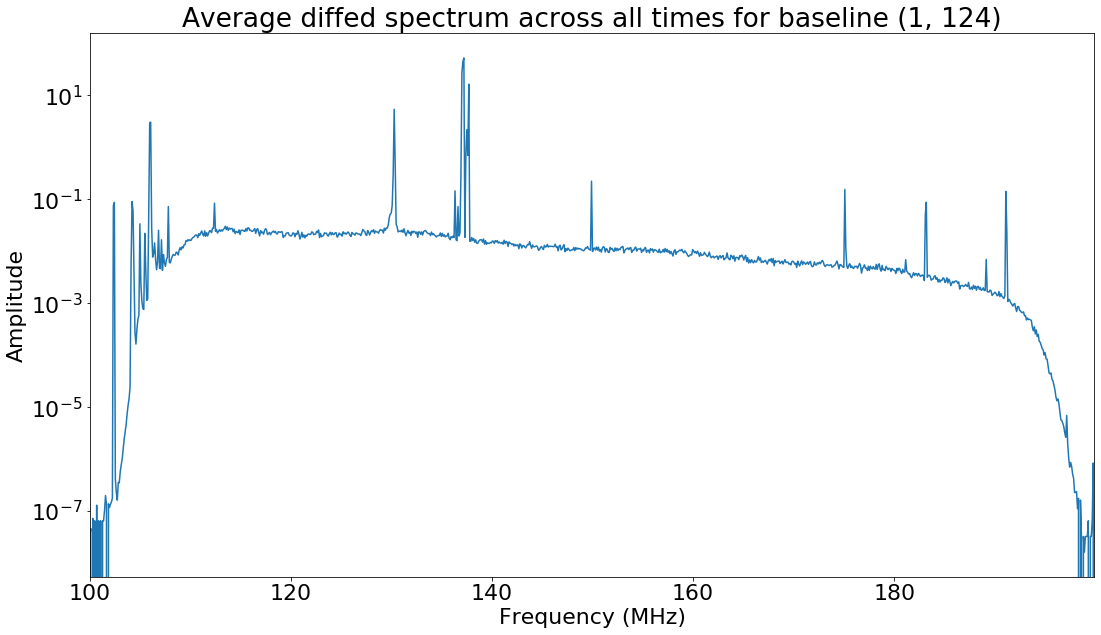

In [6]:
plt.title(f"Average diffed spectrum across all times for baseline {baseline}")
plot_avg_amplitudes(freqs_mhz, times, data)
plt.yscale('log')

We can clearly pick out peaks in this plot that correspond to signal contamination of specific frequencies. Our background appears to be somwhat wedge-shaped, sloping downward slightly as the frequency increases, which has the effect of broadening the background distribution. To find the shape of this distribution, let us now histogram the diffed visibilities from all time intervals, cutting off any signals above 0.05, the approximate upper bound for our wedge-shaped background. The cutoff at 0.05 is an attempt to limit the amount of large peaks that contaminate our background.

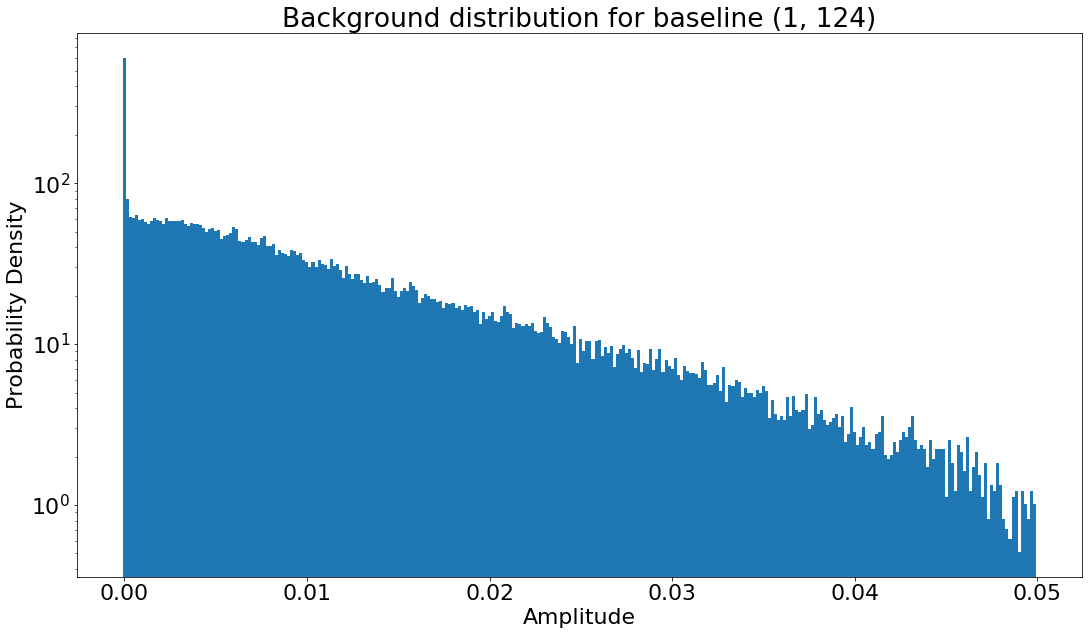

In [7]:
plot_histogram(np.abs(data).flatten(), max_amplitude=0.05)
plt.title(f"Background distribution for baseline {baseline}")
plt.yscale('log')

It's clear that our histogram is dominated by values close to zero, which likely comes from the fact that all of the spectra captured by the baseline have sharp drops near the lower and upper bounds of the frequency. This masks any meaningful insight into the shape of the distribution on top of the "wedge", so let's limit the visibility data to only that which is on the wedge. We'll take a reasonable chunk of the wedge, from about 120 MHz to 180 MHz.

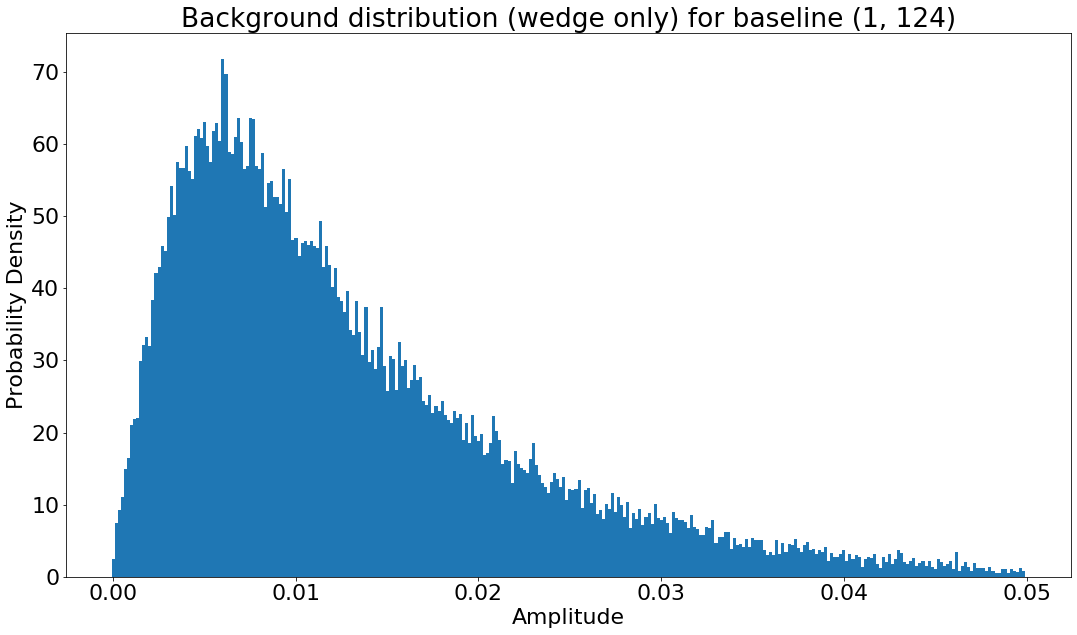

In [8]:
start = 200
end = 800
plt.title(f"Background distribution (wedge only) for baseline {baseline}")
plot_histogram(np.abs(data[:, start:end]).flatten());

A clearer shape emerges - our background is right-skewed, perhaps a lognormal or Rayleigh distribution. Because there is still some contamination that is making the tail noisier than it should be, we need more data to get a better picture. Because all of the baselines are recording the same, constant sky signal through time, we can difference the data across time for all baselines (excluding redundant pairs like (1, 1)) and histogram all the visibilities of the diffs together.

In [9]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:12], np.arange(200, 800), 'XX', filter_dupes=True)
num_times = len(set(times))
num_baselines = data.shape[0] // num_times
data = np.dstack(np.split(np.array(data), num_times))
data = np.diff(data, axis=2)
times = times[:-1]

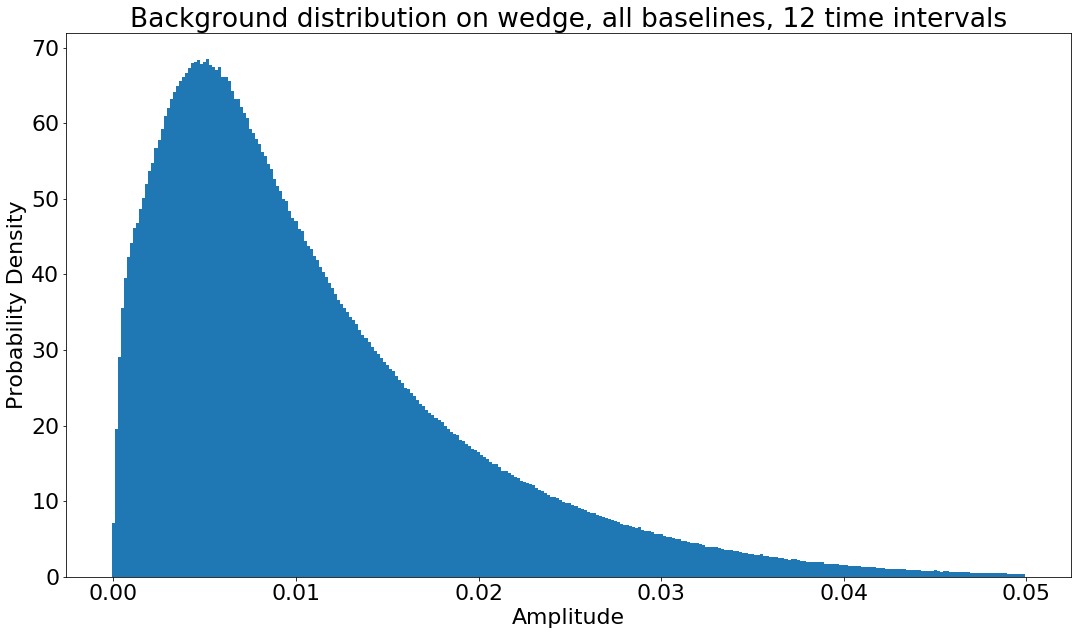

In [10]:
plt.title(f"Background distribution on wedge, all baselines, {num_times} time intervals")
plot_histogram(np.abs(data).flatten(), max_amplitude=0.05);

Now it is much clearer what our background is generally supposed to look like. Processing the data this way is beneficial for another reason - because every baseline sees the same background, if a real (non-background) signal comes in from far away, then we also expect to see it show up on all baselines. This means that if we now _average_ together the visibilities for the diffs of each baseline, it should further isolate only the background and the real signal, while "averaging away" the contamination that fluctuates sharply from baseline to baseline.

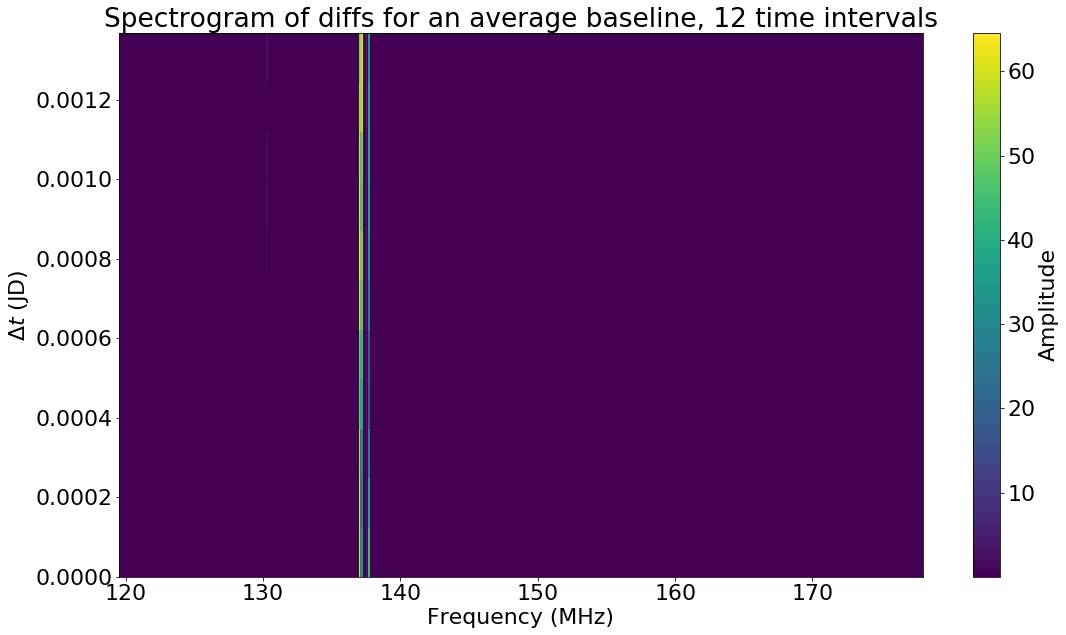

In [11]:
plt.title(f"Spectrogram of diffs for an average baseline, {num_times} time intervals")
average_amplitudes = np.transpose(np.mean(np.abs(data), axis=0))
plot_spectrogram(freqs_mhz, times, average_amplitudes)

Above is a spectrogram only for the frequencies on the wedge (120 - 180 MHz). There is still some contamination making it through this averaging process, but the maximum amplitude has been reduced (around 60 units compared to 100+ units for one baseline). Let's plot the average spectrum for this spectrogram:

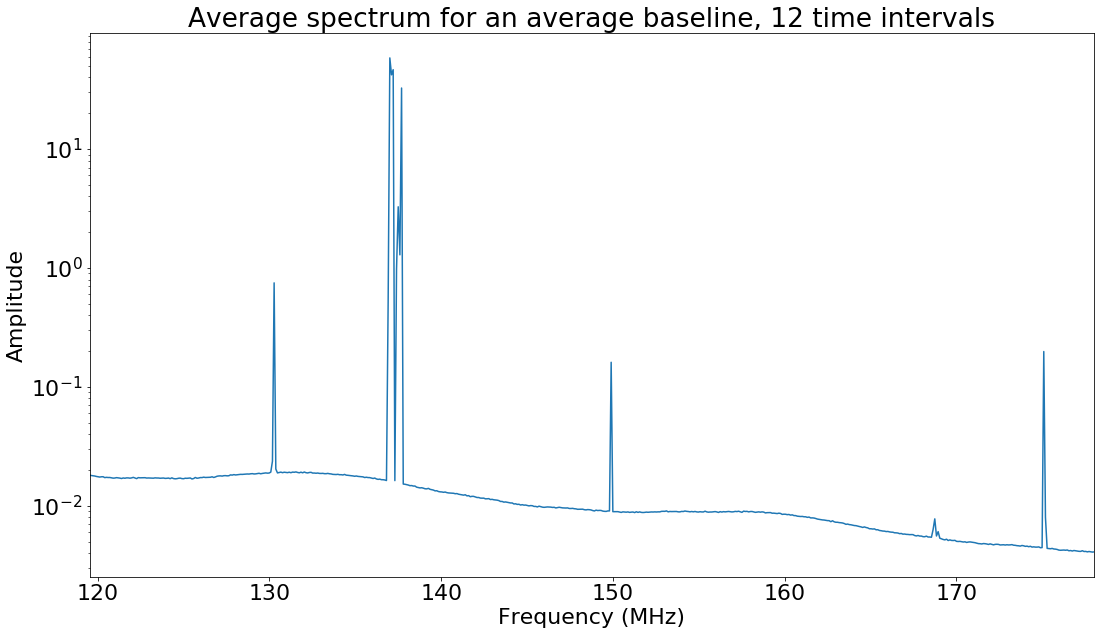

In [103]:
plt.title(f"Average spectrum for an average baseline, {num_times} time intervals")
plot_avg_amplitudes(freqs_mhz, times, average_amplitudes)
plt.yscale('log')

The background is much less noisy, and the contamination peaks are well-resolved. We explored specific sources of contamination in lab 5, but we can also use [this frequency allocation chart](https://www.ee.co.za/wp-content/uploads/2015/03/csir-035-02-2015_.jpg) to determine the particular usage of each frequency. Let's find the frequencies at which these peaks occur:

In [17]:
plot_data = np.mean(average_amplitudes, axis=0)
peaks = argrelmax(plot_data * (plot_data > 2e-2), order=1)
print(f"Peak frequencies: {freqs_mhz[peaks]}")

Peak frequencies: [130.2734375  137.01171875 137.20703125 137.5        137.6953125
 149.90234375 175.09765625]


130.27 MHz is used for "Aeronautical Mobile" communication; 137.01 MHz, 137.21 MHz, and 137.70 MHz are used for "Space operation", "Meteorological satellite", "Mobile satellite", "Space research", and "Mobile except aeronautical mobile" communication, 149.90 MHz is "Radionavigation satellite" or "Mobile satellite" communication, and 175.10 MHz is "Broadcasting". There are two additional peaks around 169 MHz that correspond to "Mobile except aeronautical mobile" communication.

It wasn't obvious in the previous amplitude versus frequency plot, but there is clearly some amount of variation in the background itself - it appears to undulate as it slopes downward. What this translates to on the distribution of this average background is several peaks at different amplitudes corresponding to each of these undulations. Let's make a histogram for this new background data, while also trying to cut out as much contamination as we can.

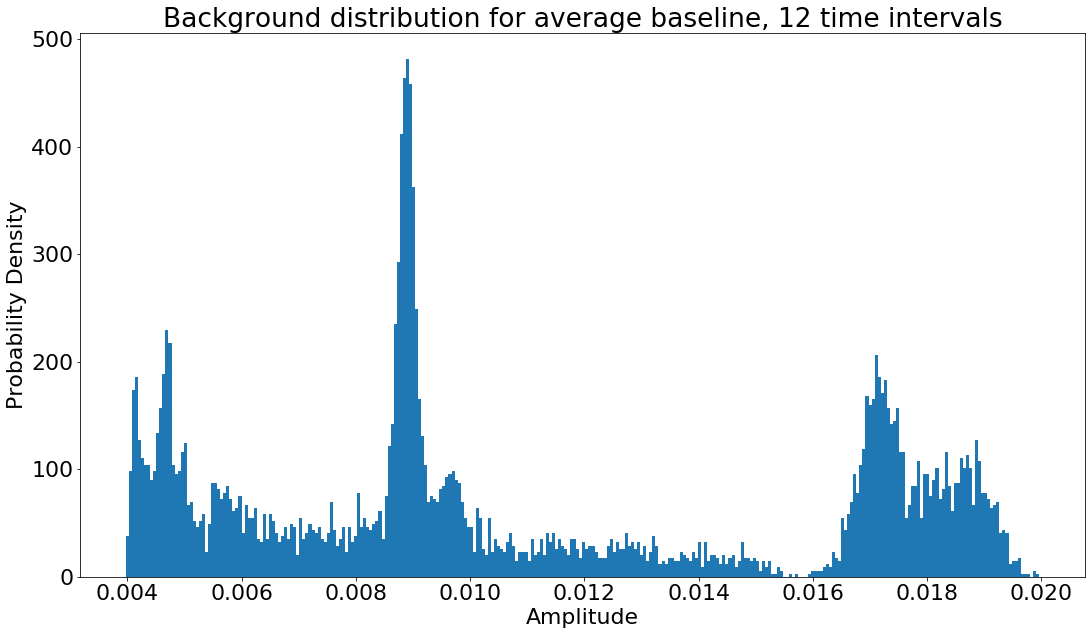

In [14]:
plt.title(f"Background distribution for average baseline, {num_times} time intervals")
plot_histogram(average_amplitudes.flatten(), max_amplitude=0.02, nbins=300);

In this averaged background, there is one large peak around 0.009 units and several smaller peaks off to each side, caused by the undulations found earlier. Because we averaged several sets of data together, the distribution of the background will have narrowed and become more Gaussian due to the central limit theorem.

Because our amplitude versus frequency plot is centered on about 150 MHz, the distribution is approximately centered on the largest peak above. If we center our point of interest at a lower frequency, however, the peaks would shift to the left, and this makes it very difficult to discern signal from noise - which peak in the above distribution is the "right" one to use when calculating the significance of some signal? Couldn't a potential signal just be background from somewhere else in the frequency spectrum?

This concern calls for a jackknife test, where the specific question we are asking is: "Does the shape of my background distribution change depending on which frequency I observe?" To compare data for this test, we subtract the distribution of data from two locations (the flat portions of two undulations) to see if there are significant differences. The amplitudes are obviously different at these two locations, but what about the shape of the distribution around each amplitude?

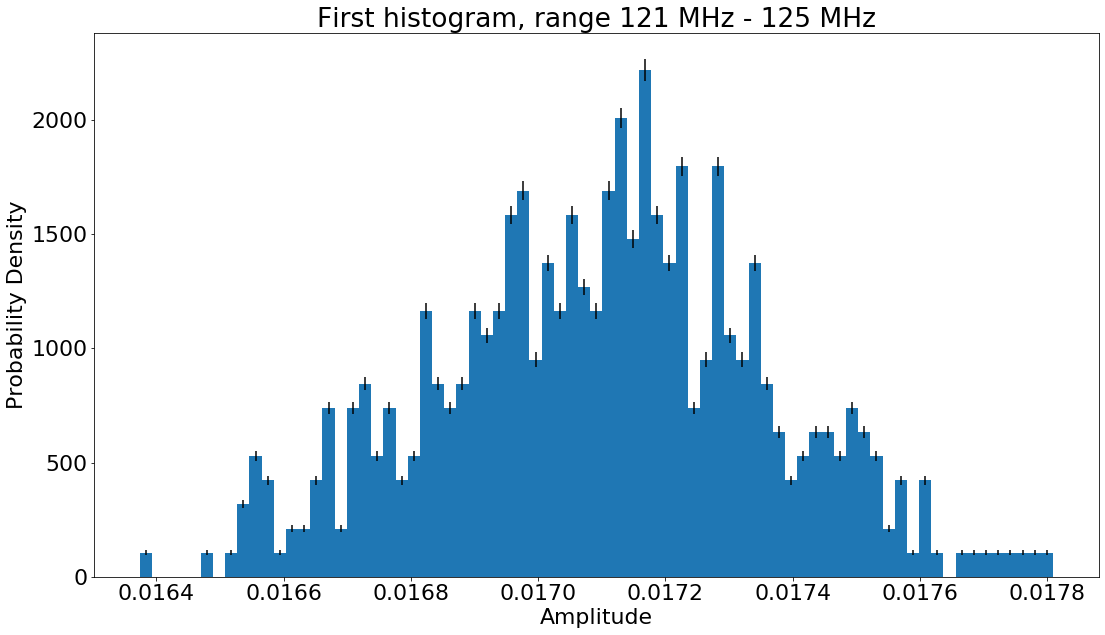

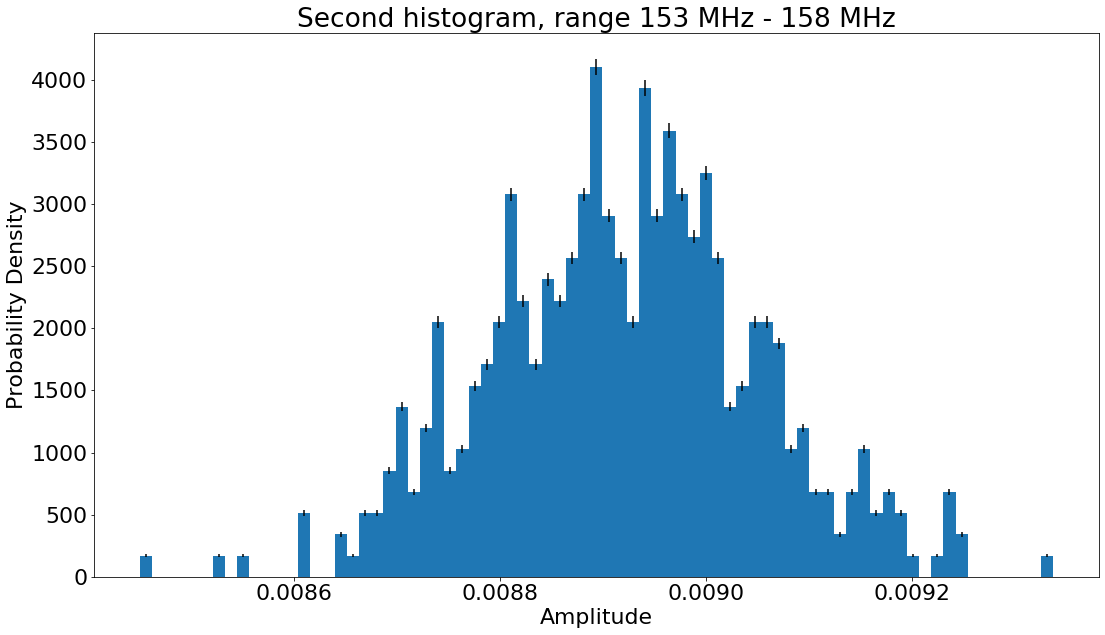

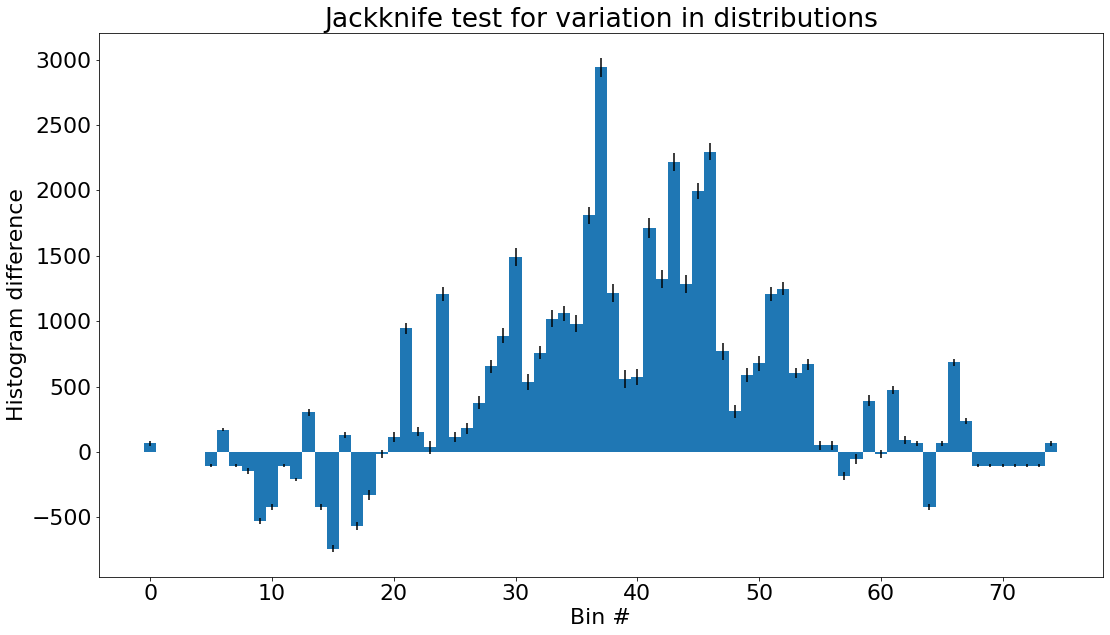

In [111]:
# About 121 MHz to 125 MHz
plt.figure()
plt.title('First histogram, range 121 MHz - 125 MHz')
plot_histogram(average_amplitudes[:, 15:60].flatten(), nbins=75, errorbars=True)
# About 153 MHz to 158 MHz
plt.figure()
plt.title('Second histogram, range 153 MHz - 158 MHz')
hist_2 = plot_histogram(average_amplitudes[:, 345:390].flatten(), nbins=75, errorbars=True)

difference = hist_2 - hist_1
plt.figure()
plt.title('Jackknife test for variation in distributions')
plt.ylabel('Histogram difference')
plt.xlabel('Bin #')
plt.bar(range(len(difference)), difference, width=1, yerr=np.sqrt(hist_1 + hist_2));

Our jackknife test tells us that our concern is valid - the shape of the distribution does indeed change from plateau to plateu on the background. Because there is a positive "chunk" in the middle of the jackknife plot and negative "chunks" on the left and right, this shows that at the central frequency plateau (around 153 - 158 MHz) the background has a taller and narrower distribution than at the leftmost plateau (around 121 - 125 MHz).

Based on this test and our earlier results, we can identify some cuts of our data to eliminate changes in the distribution due to the frequencies we're observing. We want a region of the spectrum where there is no noticable signal contamination, which also lies on a plateau between one of the several undulations we observe in the background. Let's recalculate the average visibility histogram with these conditions applied:

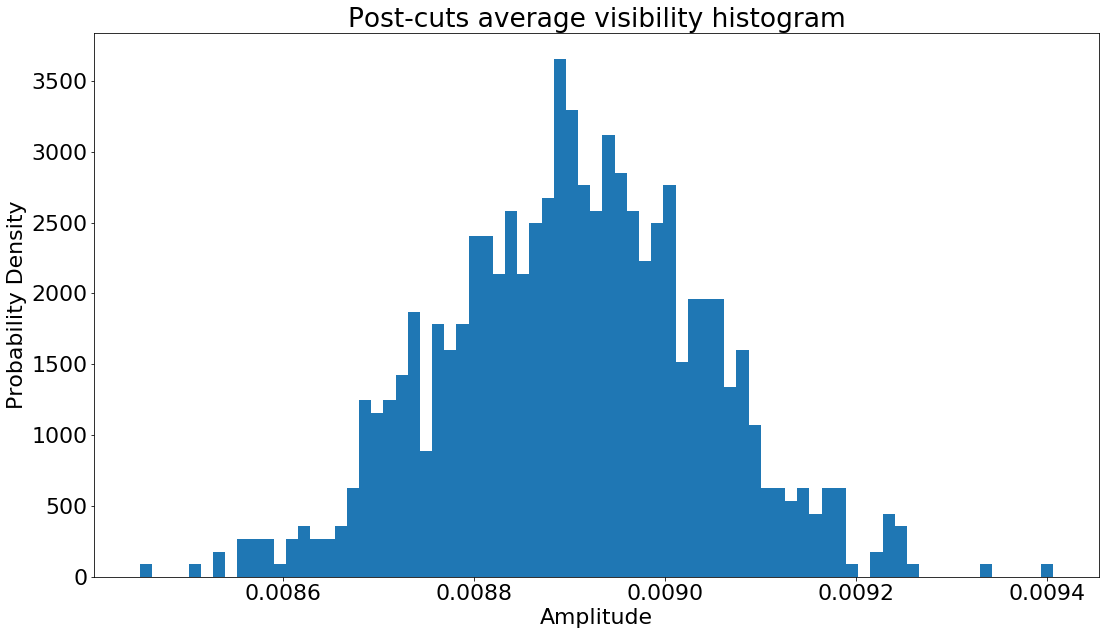

In [115]:
# About 150 MHz to 158 MHz
cut_data = average_amplitudes[:, 315:395]
plt.title('Post-cuts average visibility histogram')
plot_histogram(cut_data, max_amplitude=2e-2, nbins=75);

Compared to the entire average background histogram found earlier, this one focuses on just one range of frequencies rather than all frequencies. This isn't ideal when searching for signals further away from the background plateau, but different histograms may be generated for those plateaus instead. A candidate signal in this space would have a far higher significance than it would previously - recall that with a larger range of frequencies, the histogram was broadened with more noise in the tails:

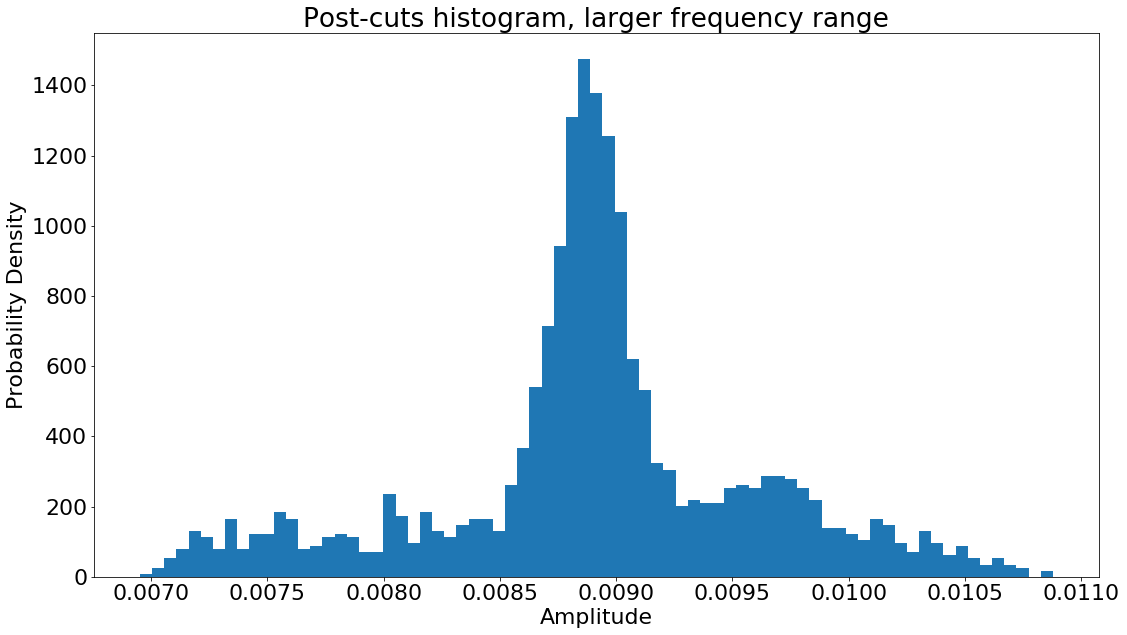

In [118]:
cut_data = average_amplitudes[:, 250:450]
plt.title('Post-cuts histogram, larger frequency range')
plot_histogram(cut_data, max_amplitude=2e-2, nbins=75);

It makes sense for us to remove data in order to increase the sensitivity, because adding in more data to construct our histogram will cause the distribution to broaden and reduce the sensitivity.